In [128]:
import numpy as np, matplotlib.pyplot as plt
import scipy.optimize as optimize
from astropy.io import ascii as asc, fits as pyfits
from analysis.composite_errors import random_pdf
from analysis.MC_contours import contours, confidence

FULL_PATH = '/Users/kaitlynshin/GoogleDrive/NASA_Summer2015/'
CUTOFF_SIGMA = 4.0
CUTOFF_MASS = 6.0

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [129]:
# reading in data generated by EBV_corrections.py
corr_tbl = asc.read(FULL_PATH+'Main_Sequence/mainseq_corrections_tbl.txt',guess=False,
                Reader=asc.FixedWidthTwoLine)
zspec0 = np.array(corr_tbl['zspec0'])
no_spectra  = np.where((zspec0 <= 0) | (zspec0 > 9))[0]
yes_spectra = np.where((zspec0 >= 0) & (zspec0 < 9))[0]

stlr_mass = np.array(corr_tbl['stlr_mass'])
filts = np.array(corr_tbl['filt'])
sfr = np.array(corr_tbl['met_dep_sfr'])
dust_corr_factor = np.array(corr_tbl['dust_corr_factor'])
filt_corr_factor = np.array(corr_tbl['filt_corr_factor'])
nii_ha_corr_factor = np.array(corr_tbl['nii_ha_corr_factor'])
corr_sfrs = sfr+filt_corr_factor+nii_ha_corr_factor+dust_corr_factor

# defining a flux sigma and mass cutoff
good_sig_iis = np.where((corr_tbl['flux_sigma'] >= CUTOFF_SIGMA) & (stlr_mass >= CUTOFF_MASS))[0]
n = len(good_sig_iis)

In [130]:
sigmas = corr_tbl['meas_errs'][good_sig_iis].data
mass = stlr_mass[good_sig_iis]
sfrs = corr_sfrs[good_sig_iis]

z_sp = zspec0[good_sig_iis]
badz_iis = np.array([x for x in range(len(z_sp)) if z_sp[x] < 0 or z_sp[x] > 9])
filt_lambda_list = {'NB704':7045.0, 'NB711':7126.0, 'NB816':8152.0, 'NB921':9193.0, 'NB973':9749.0}
ffs = filts[good_sig_iis]
for ff in filt_lambda_list.keys():
    badf_match = np.where(ffs[badz_iis] == ff)[0]
    z_sp[badz_iis[badf_match]] = (filt_lambda_list[ff]/6562.8) - 1
    
mz_data = np.vstack([mass, z_sp]).T

eqn_str = r'$\log(SFR) = \alpha \log(M) + \beta z + \gamma$'
def func(data, a, b, c):
    return a*data[:,0] + b*data[:,1] + c

params00, pcov = optimize.curve_fit(func, mz_data, sfrs)
perr = np.sqrt(np.diag(pcov))

### nbia_mainseq sample

In [131]:
newha = pyfits.open(FULL_PATH+'NewHa/NewHa.fits')
newhadata = newha[1].data

tempm = newhadata['LOGM']
tempsfr = newhadata['LOGSFR_HA']
templha = newhadata['L_HA']
tempagn = newhadata['AGN']
good_ii = np.where((tempm > 0) & (tempsfr != 0) & (templha != 0) & (tempagn != 1))[0]
newhadata = newhadata[good_ii]

newha_zspec = newhadata['Z_SPEC']
newha_logm = newhadata['LOGM']
newha_logm_err = newhadata['LOGM_ERR']
newha_logsfrha = newhadata['LOGSFR_HA']
newha_logsfrha_uperr = newhadata['LOGSFR_HA_UPERR']
newha_logsfrha_lowerr = newhadata['LOGSFR_HA_LOWERR']
newha_logsfr_err = np.sqrt(newha_logsfrha_uperr**2/2 + newha_logsfrha_lowerr**2/2)

newha_mzdata = np.vstack([newha_logm, newha_zspec]).T

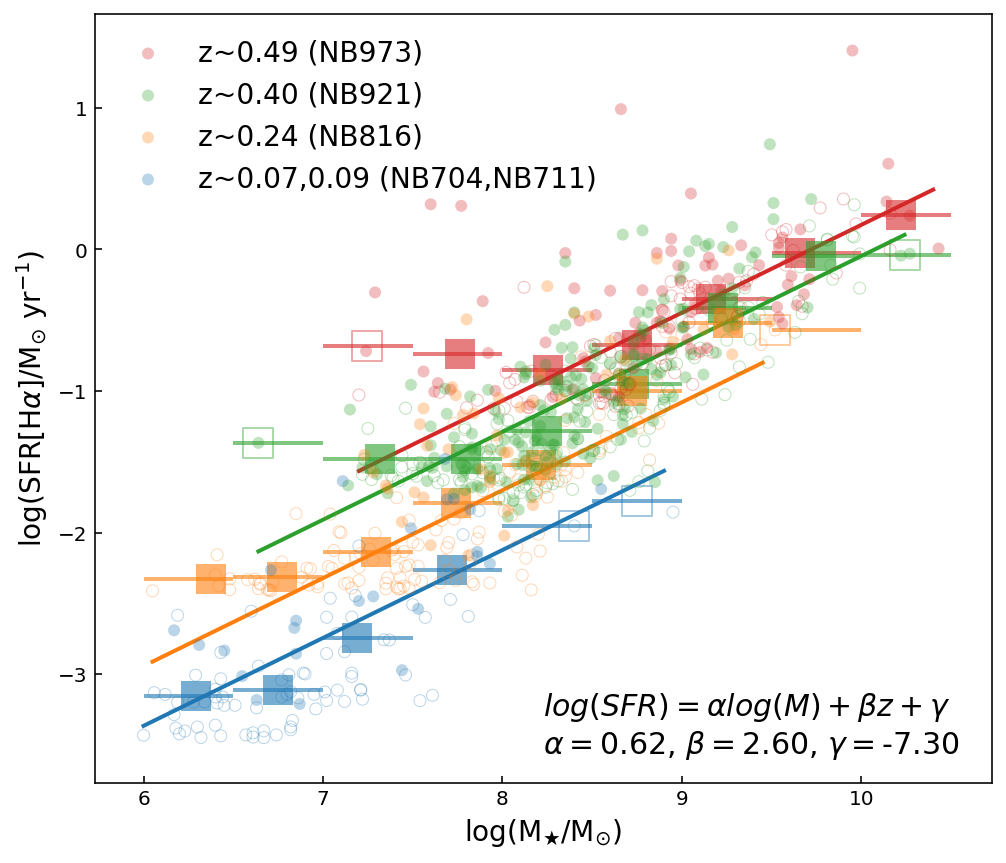

In [132]:
from plot_nbia_mainseq import make_redshift_graph
import matplotlib as mpl

# defining an approximate redshift array for plot visualization
z_arr0 = np.array([7045.0, 7126.0, 8152.0, 9193.0, 9749.0])/6563.0 - 1
z_arr0 = np.around(z_arr0, 2)
z_arr  = np.array(z_arr0, dtype='|S9')
z_arr[0] = ",".join(z_arr[:2])
z_arr = np.delete(z_arr, 1)
z_arr  = np.array([x+'0' if len(x)==3 else x for x in z_arr])


cwheel = [np.array(mpl.rcParams['axes.prop_cycle'])[x]['color'] for x in range(4)]
newha_col = np.array(mpl.rcParams['axes.prop_cycle'])[4]['color']

f, ax = plt.subplots()
make_redshift_graph(f, ax, z_arr, corr_sfrs, stlr_mass, zspec0, filts, good_sig_iis, cwheel)
plt.subplots_adjust(hspace=0.01, wspace=0.01, right=0.99, top=0.98, left=0.1, bottom=0.09)

plt.show()

## overlaying new_ha

In [133]:
nh_z_arr = np.append(z_arr, '%.2f'%np.mean(newha_zspec))
nh_cwheel = [np.array(mpl.rcParams['axes.prop_cycle'])[x]['color'] for x in range(5)]

sfrs_with_newha  = np.concatenate((corr_sfrs, newha_logsfrha))
mass_with_newha  = np.concatenate((stlr_mass, newha_logm))
zspec_with_newha = np.concatenate((zspec0, newha_zspec))
filts_with_newha = np.concatenate((filts, np.array(['NEWHA']*len(newha_logsfrha))))
mz_data_with_newha = np.concatenate((mz_data, newha_mzdata))

nh_good_sig_iis = np.concatenate((good_sig_iis, np.arange(len(corr_sfrs), len(sfrs_with_newha))))
nh_ffarr=['NB7', 'NB816', 'NB921', 'NB973', 'NEWHA']
nh_llarr=['NB704,NB711', 'NB816', 'NB921', 'NB973', 'NEWHA']

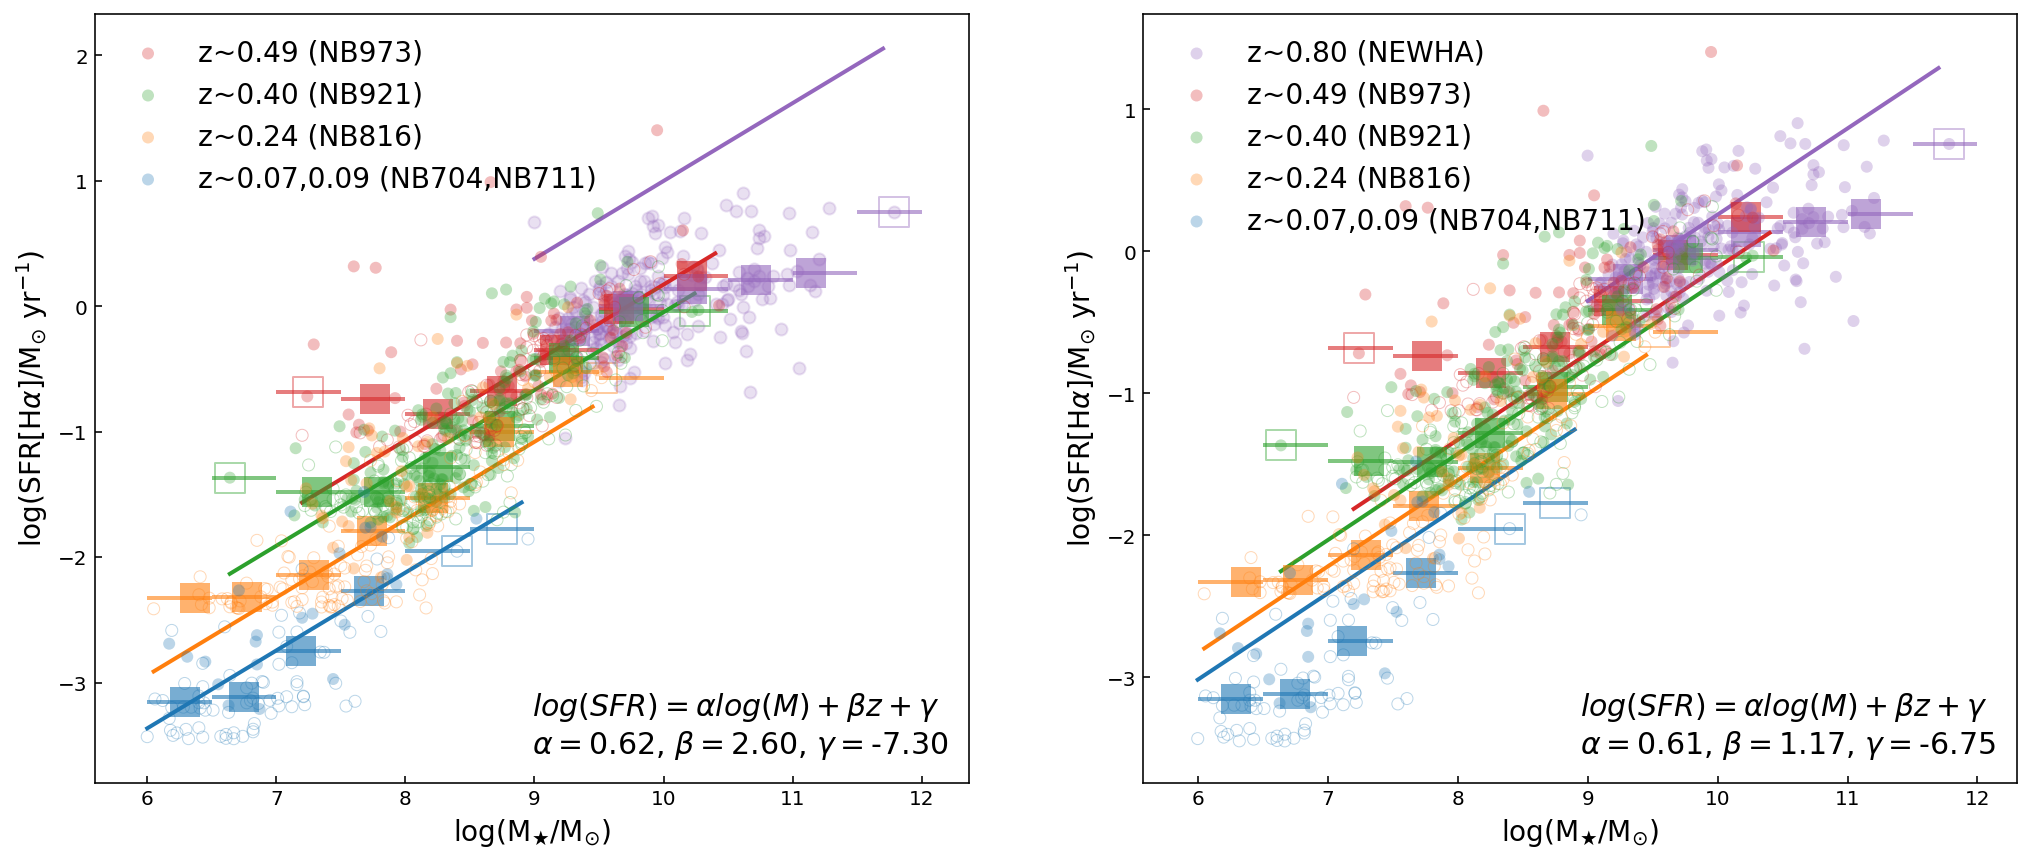

In [172]:
# TODO: redo this plot for metallicity-dep sfr
import plot_nbia_mainseq
reload(plot_nbia_mainseq)
from plot_nbia_mainseq import plot_zdep_avg_sfrs

f, axes = plt.subplots(1,2)
for i,ax in enumerate(axes):
    if i==0:
        make_redshift_graph(f, ax, z_arr, corr_sfrs, stlr_mass, zspec0, filts, good_sig_iis, cwheel)

        ax.plot(newha_logm, newha_logsfrha, 'o', c=newha_col, alpha=0.2, zorder=1)
        plot_zdep_avg_sfrs(ax, newha_logm, newha_logsfrha, newha_col)

        mrange = np.arange(min(newha_logm), max(newha_logm), 0.1)
        avgz = np.array([np.mean(newha_zspec)]*len(mrange))
        tmpdata = np.vstack([mrange, avgz]).T
        ax.plot(mrange, func(tmpdata, *params00), color=newha_col, lw=2)
    else:
        make_redshift_graph(f, ax, nh_z_arr, sfrs_with_newha, mass_with_newha, zspec_with_newha, 
                            filts_with_newha, nh_good_sig_iis, nh_cwheel,
                            ffarr=nh_ffarr, llarr=nh_llarr)


plt.subplots_adjust(hspace=0.01, right=0.99, top=0.98, left=0.1, bottom=0.09)
f.set_size_inches(15,6)
plt.show()

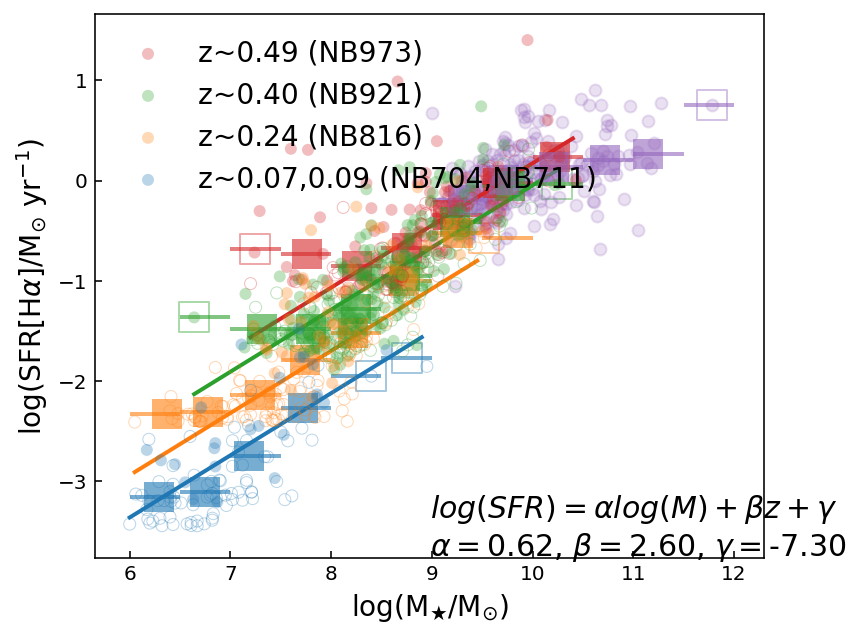

In [176]:
f, ax = plt.subplots(1,1)
make_redshift_graph(f, ax, z_arr, corr_sfrs, stlr_mass, zspec0, filts, good_sig_iis, cwheel)
ax.plot(newha_logm, newha_logsfrha, 'o', c=newha_col, alpha=0.2, zorder=1)
plot_zdep_avg_sfrs(ax, newha_logm, newha_logsfrha, newha_col)
f.set_size_inches(6,5)

sSFR a*log(1+z)+b params: [-0.18026247 -9.59047802]


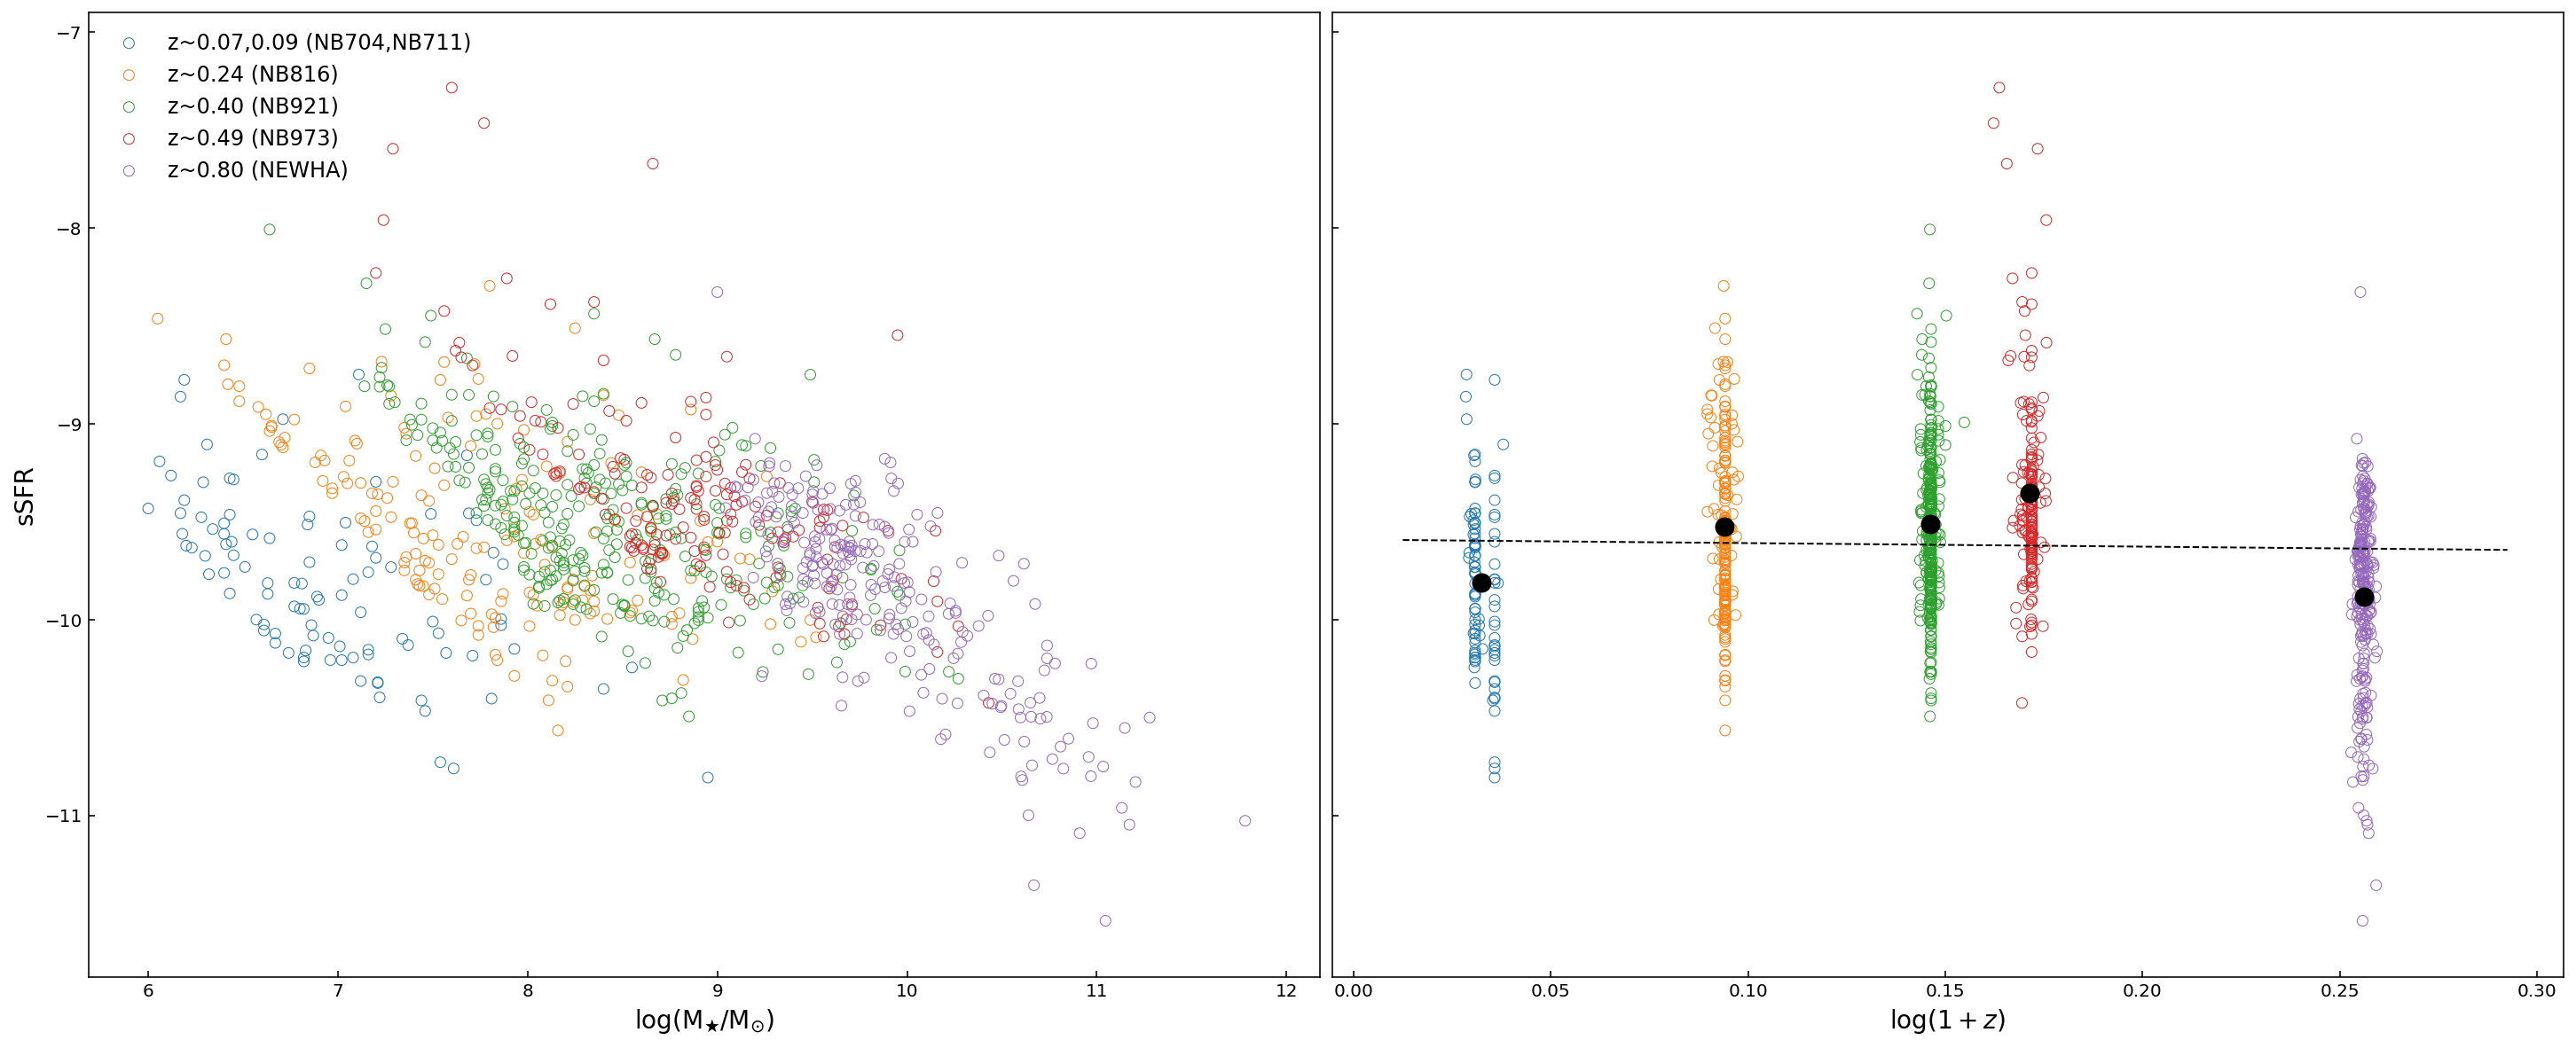

In [135]:
import plot_nbia_mainseq
reload(plot_nbia_mainseq)
from plot_nbia_mainseq import make_ssfr_graph

f, axes = plt.subplots(1,2, sharey=True)

sfrs_with_newha00  = np.concatenate((sfrs, newha_logsfrha))
mass_with_newha00  = np.concatenate((mass, newha_logm))
zspec_with_newha00 = np.concatenate((z_sp, newha_zspec))
filts_with_newha00 = np.concatenate((ffs, np.array(['NEWHA']*len(newha_logsfrha))))

make_ssfr_graph(f, axes, sfrs_with_newha00, mass_with_newha00, filts_with_newha00, zspec_with_newha00, 
                nh_cwheel, nh_z_arr, ffarr=nh_ffarr, llarr=nh_llarr)

f.set_size_inches(25,10)

### using HA luminosity and then correcting that with nii/ha instead of directly using SFR lumin in the table

In [136]:
newhadata.columns

ColDefs(
    name = 'SPEC_ID'; format = '11A'; disp = 'A11'
    name = 'AGN'; format = 'I'; disp = 'I1'
    name = 'Z_SPEC'; format = 'E'; disp = 'E'
    name = 'LOGM'; format = 'E'; unit = 'dex'; disp = 'E'
    name = 'LOGM_ERR'; format = 'E'; unit = 'dex'; disp = 'E'
    name = 'LOGSFR_SED'; format = 'E'; unit = 'dex'; disp = 'E'
    name = 'LOGSFR_SED_ERR'; format = 'E'; unit = 'dex'; disp = 'E'
    name = 'LOGSFR_SED_CF'; format = 'E'; unit = 'dex'; disp = 'E'
    name = 'LOGSFR_SED_CF_ERR'; format = 'E'; unit = 'dex'; disp = 'E'
    name = 'U_FLAG'; format = 'I'; disp = 'I1'
    name = 'TAU_V'; format = 'E'; disp = 'F8.3'
    name = 'TAU_VERR'; format = 'E'; disp = 'F8.3'
    name = 'A_HA'; format = 'E'; disp = 'F8.3'
    name = 'NB_3SIG'; format = 'I'; disp = 'I'
    name = 'F_NB'; format = 'E'; unit = '1E-17erg/s/cm2'; disp = 'F8.3'
    name = 'F_NB_ERR'; format = 'E'; unit = '1E-17erg/s/cm2'; disp = 'F8.3'
    name = 'F_HA'; format = 'E'; unit = '1E-17erg/s/cm2'; disp = 'F8.3'


In [137]:
from mainseq_corrections import niiha_oh_determine

In [138]:
# L_HA *is* corrected for N II. compare flux HA to flux NB and there's diffs btwn the two .
# use the SFR_CF (dust attenuated corrected SFR), reverse engineer that to get luminosity. 

# there's three diff SFRs. LOG_SFR_HA should just be the HA luminosity converted to a SFR.
# LOGS_FR_CF is the dust corrected HA SFR.

In [139]:
# LOG_SFR_HA_CF - LOG_SFR_HA = 0.4*A(HA)
# use L_HA and NII/HA ratio to get the proper conversion to get it to a SFR [ L_HA -> SFR(NII/Ha) ]
# then add the component for dust and that should give dust corrected L_HA w/ the metallicity dependent conversion 
# [ dust-corrected metallicity-dependent H-alpha SFR = logSFR(NII-dependent) + 0.4*A_HA ]

In [140]:
A_HA = newhadata['A_HA']

In [141]:
# #  7.9E-42 is conversion btwn L and SFR based on Kennicutt 1998 for Salpeter IMF. 
# #  We use 1.8 to convert to Chabrier IMF.
# orig_sfr = np.log10(7.9/1.8) - 42 + orig_lums

In [142]:
logsfr_ha_cf = newhadata['LOGSFR_HA_CF'] # dust attenuated
logsfr_ha = newhadata['LOGSFR_HA'] # observed

In [143]:
l_ha

array([ 49.97395325,  42.63362885,  44.30039978,  44.43671036,
        41.81154251,  44.30368805,  41.6101799 ,  42.3817215 ,
        43.36140823,  46.45529175,  45.60047913,  46.04387665,
        44.0402832 ,  42.18532181,  42.31666183,  42.58211517,
        43.54679871,  44.24171448,  44.2212944 ,  42.6238327 ,
        52.86151886,  42.65457535,  43.1411438 ,  42.25806427,
        42.34308243,  43.46867752,  43.00766754,  42.37200165,
        42.58210373,  44.02956009,  42.3242569 ,  42.10654068,
        42.30688095,  41.79908752,  54.70995331,  46.70566559,
        42.05648804,  53.97045517,  42.45478821,  42.17779922,
        43.85904694,  43.90957642,  46.40885925,  43.60099792,
        45.13132095,  63.42158127,  44.3773613 ,  45.00217438,
        42.89229202,  45.65407944,  43.2872467 ,  52.60287857,
        43.85903168,  43.25909805,  43.62978745,  43.06222153,
        43.71177292,  42.73388672,  42.50995255,  42.41674423,
        49.87055206,  42.7341423 ,  47.12465286,  45.54

In [144]:
# newha_logsfrha

In [145]:
min(l_ha), max(l_ha)

(41.201145, 67.840485)

In [146]:
# log_SFR_LHa

In [147]:
newhadata['L_HA']

array([  8.97395229,   1.63362825,   3.30039787,   3.43670917,
         0.81154251,   3.30368948,   0.61017859,   1.38171983,
         2.36140943,   5.4552927 ,   4.6004777 ,   5.04387712,
         3.0402832 ,   1.18532193,   1.31666017,   1.58211637,
         2.54680014,   3.24171591,   3.2212944 ,   1.62383449,
        11.86151981,   1.65457439,   2.14114547,   1.2580626 ,
         1.34308398,   2.468678  ,   1.37200224,   1.58210301,
         1.3242563 ,   1.10653925,   1.30687976,   0.7990877 ,
        13.70995426,   5.7056675 ,   1.05648851,  12.97045517,
         1.45478773,   1.17779839,   2.85904551,   2.90957522,
         5.40885735,   2.60099649,   4.13132238,   3.37736154,
         4.00217581,   1.8922925 ,   4.65407848,   2.28724766,
        11.60287857,   2.85903287,   2.25909972,   2.6297884 ,
         2.06222034,   2.71177411,   1.7338872 ,   1.50995433,
         1.41674531,   8.87055111,   1.73414409,   4.54382277,
         1.78720272,   0.82504994,   3.88266253,   0.85

In [148]:
len(l_ha)

265

In [149]:
min(logSFR), max(logSFR)

(-0.13317417437342272, 26.480127585914055)

In [150]:
min(nii6583_ha), max(nii6583_ha)

(0.032918345, 0.41704425)

In [151]:
min(logOH), max(logOH)

(-3.9129037857055664, -3.2367954254150391)

sSFR a*log(1+z)+b params: [-0.35173366 -9.57479399]


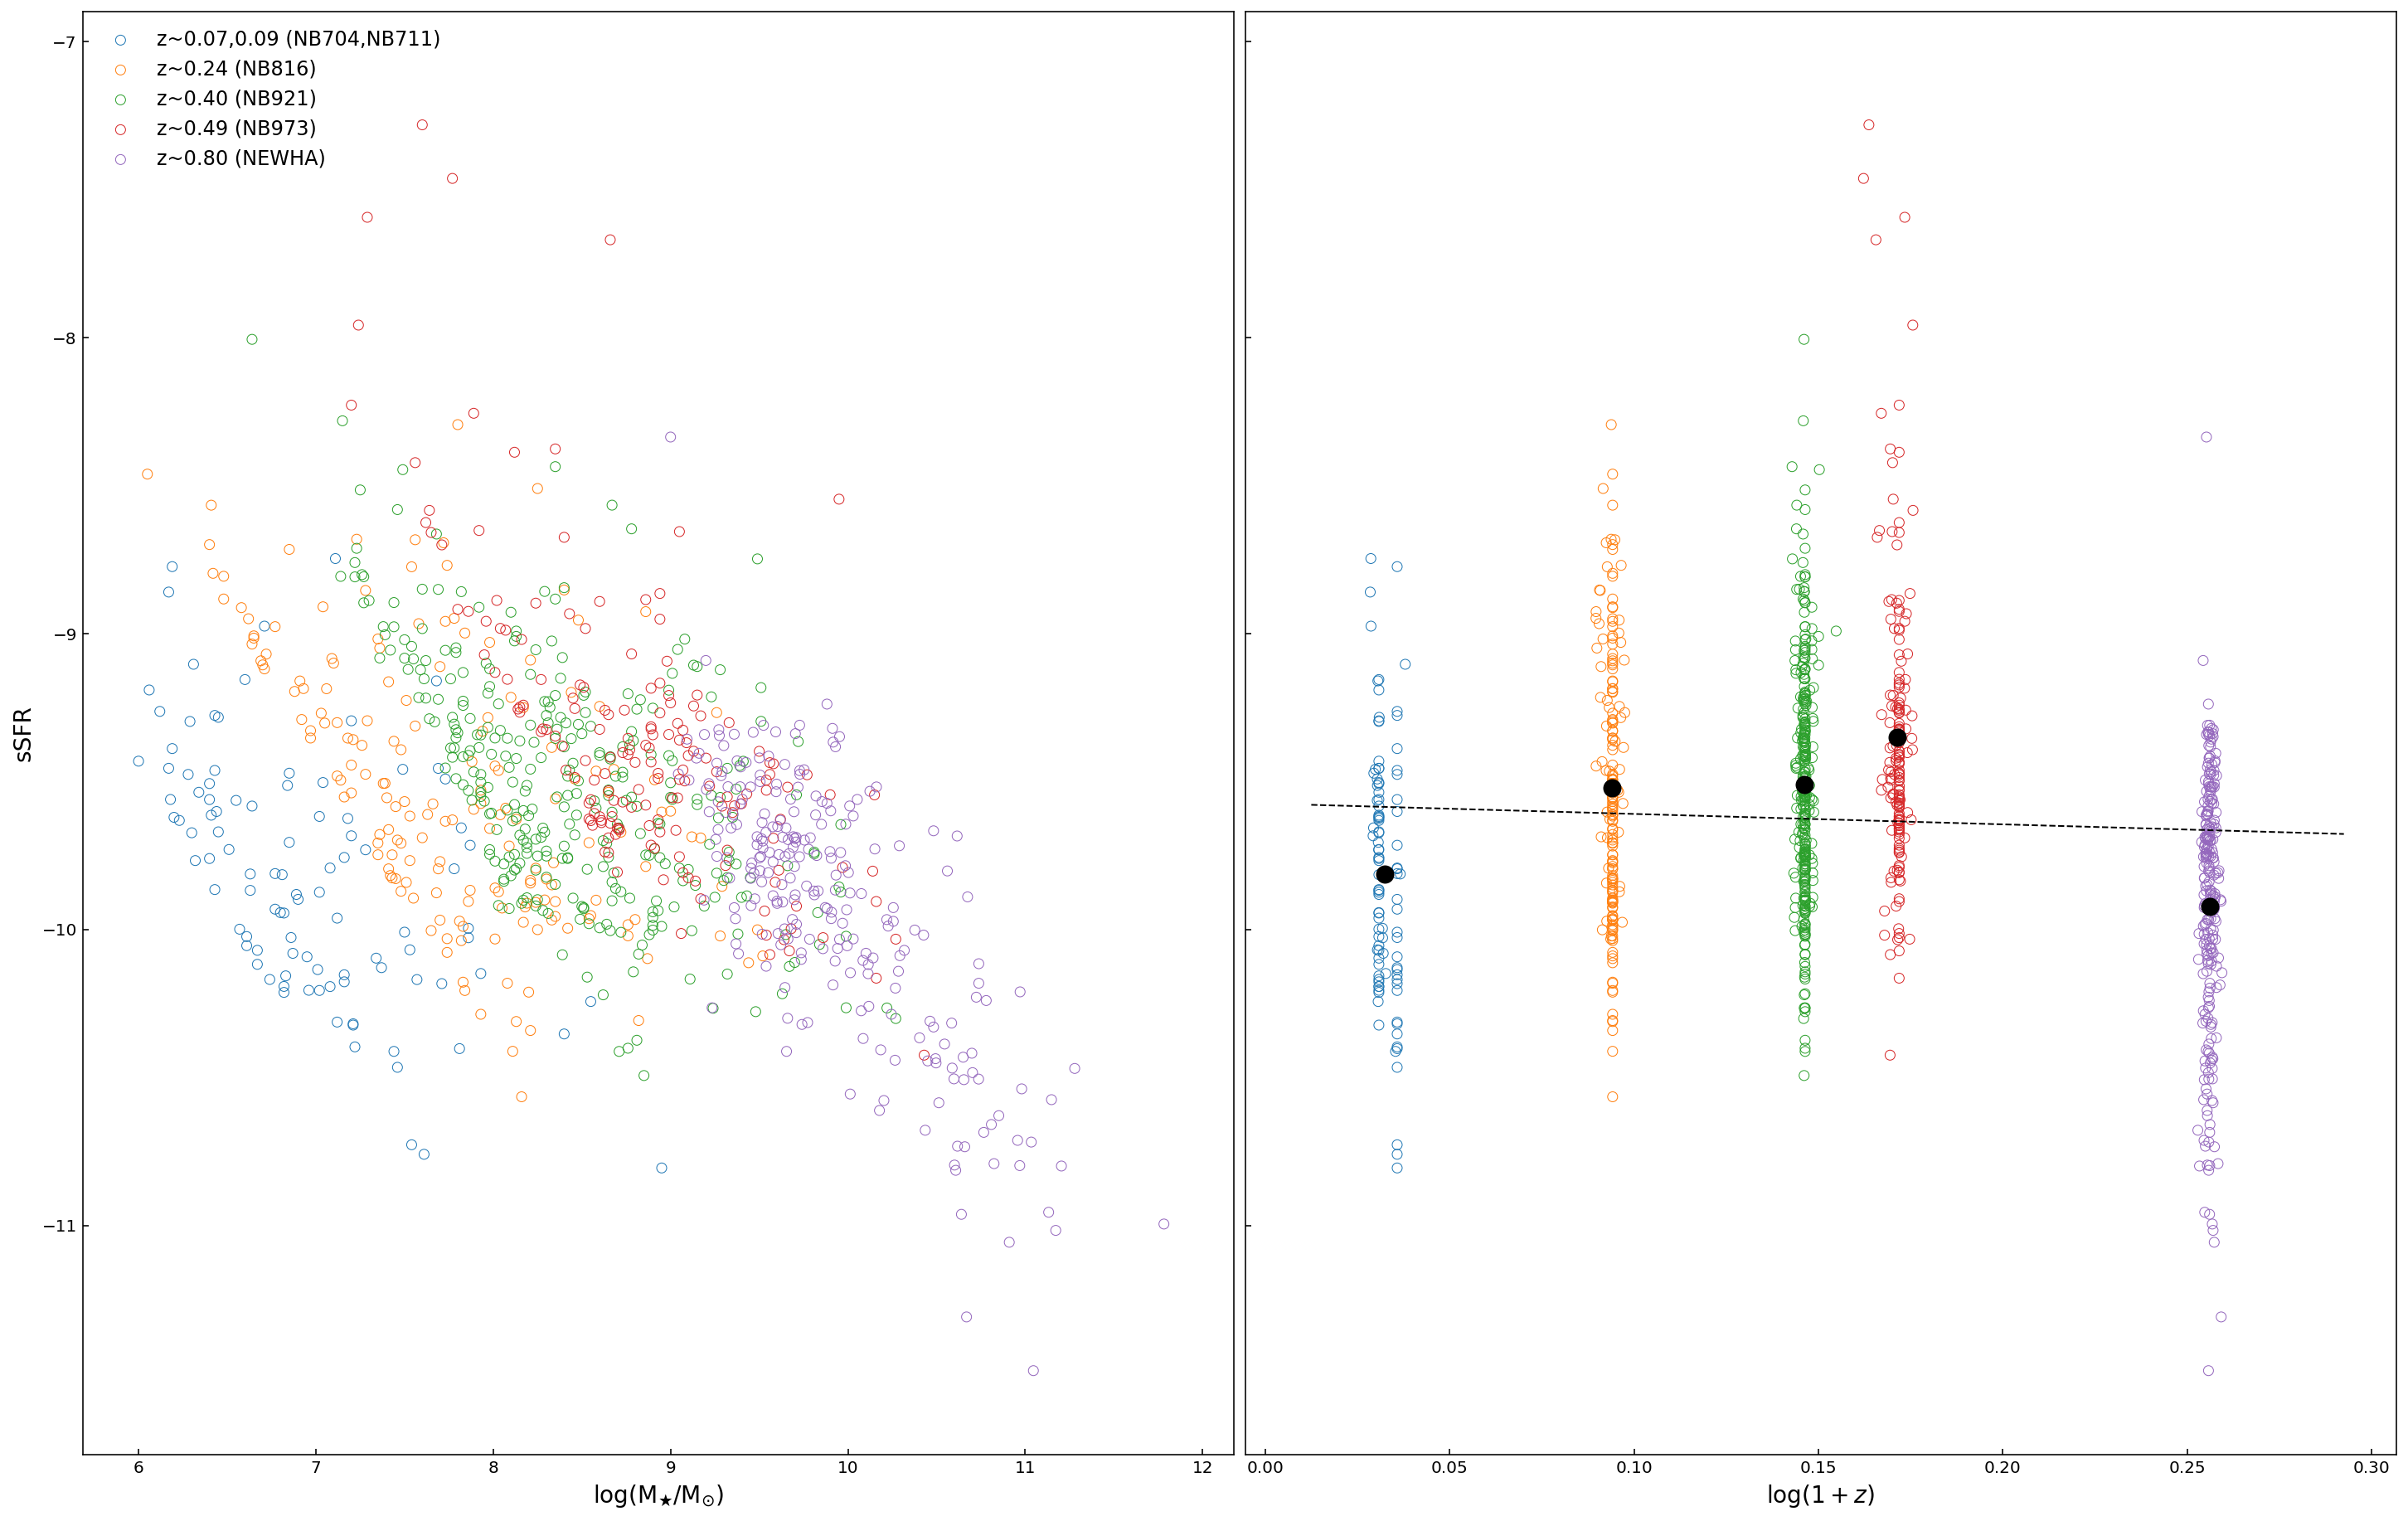

In [170]:
l_ha = np.log10(newhadata['L_HA']) + 41 # ha luminosity
nii_ha_best = newhadata['NII_HALPHA_BEST']
nii6583_ha = nii_ha_best * 2.96/(1+2.96)

logOH = niiha_oh_determine(np.log10(nii6583_ha), 'PP04_N2') - 12   # since this code estimates log(O/H)+12
y = logOH + 3.31 
log_SFR_LHa = -41.34 + 0.39*y + 0.127*y**2 # metallicity-dependent SFR

logSFR = log_SFR_LHa + l_ha  # + 0.4*A_HA #-(np.log10(7.9/1.8) - 42)


f, axes = plt.subplots(1,2, sharey=True)

sfrs_with_newha00  = np.concatenate((sfrs, logSFR))
mass_with_newha00  = np.concatenate((mass, newha_logm))
zspec_with_newha00 = np.concatenate((z_sp, newha_zspec))
filts_with_newha00 = np.concatenate((ffs, np.array(['NEWHA']*len(newha_logsfrha))))

make_ssfr_graph(f, axes, sfrs_with_newha00, mass_with_newha00, filts_with_newha00, zspec_with_newha00, 
                nh_cwheel, nh_z_arr, ffarr=nh_ffarr, llarr=nh_llarr)

# [ax.set_ylim(ymax=8) for ax in axes]
f.set_size_inches(25,16)
plt.show()

In [171]:
min(sfrs_with_newha00-mass_with_newha00), max(sfrs_with_newha00-mass_with_newha00)

(-11.490490530534501, -7.2822412181195997)

In [ ]:
# log(sSFR) = \alpha'*log(M)**2 + \alpha*log(M) + \beta*z + \gamma